In [41]:
import h5py
import bs4
import pandas as pd
import numpy as np
import requests
import random
import matplotlib.pyplot as plt;
from dateutil.parser import parse
import datetime
import collections

### NOTEBOOK STATE VARIABLES

In [42]:
scraping_data_initialization = False;

### HDF5 INIT

In [43]:
date_now = datetime.datetime.now();
LAST_SEASON = date_now.year+1 if date_now.month >= 11 else date_now.year;
FIRST_SEASON = 2010;
NUMBER_OF_SEASON = LAST_SEASON-FIRST_SEASON;
RANGE = range(FIRST_SEASON,LAST_SEASON+1);

NBA_TEAMS = {
    "ATL": (RANGE, None, "Atlanta Hawks"),
    "BOS": (RANGE, None, "Boston Celtics"),
    "BRK": (range(2013,LAST_SEASON+1), None, "Brooklyn Nets"),
    "NJN": (range(FIRST_SEASON,2012+1), "BRK"),
    "CHO": (range(2015,LAST_SEASON+1), None, "Charlotte Hornets"),
    "CHA": (range(FIRST_SEASON, 2014+1), "CHO"),
    "CHI": (RANGE, None, "Chicago Bulls"),
    "CLE": (RANGE, None, "Cleveland Cavaliers"),
    "DAL": (RANGE, None, "Dallas Mavericks"),
    "DEN": (RANGE, None, "Denver Nuggets"),
    "DET": (RANGE, None, "Detroit Pistons"),
    "GSW": (RANGE, None, "Golden State Warriors"),
    "HOU":(RANGE, None, "Houston Rockets"),
    "IND": (RANGE, None, "Indiana Pacers"),
    "LAC": (RANGE, None, "Los Angeles Clippers"),
    "LAL": (RANGE, None, "Los Angeles Lakers"),
    "MEM": (RANGE, None, "Memphis Grizzlies"),
    "MIA": (RANGE, None, "Miami Heat"),
    "MIL": (RANGE, None, "Milwaukee Bucks"),
    "MIN": (RANGE, None, "Minnesota Timberwolves"),
    "NOP": (range(2014,LAST_SEASON+1), None, "New Orleans Pelicans"),
    "NOH": (range(FIRST_SEASON,2013+1), "NOP"),
    "NYK": (RANGE, None, "New York Knicks"),
    "OKC": (RANGE, None, "Oklahoma City Thunder"),  
    "ORL": (RANGE, None, "Orlando Magic"),
    "PHI": (RANGE, None, "Philadelphia 76ers"),
    "PHO": (RANGE, None, "Phoenix Suns"),
    "POR": (RANGE, None, "Portland Trail Blazers"),
    "SAC": (RANGE, None, "Sacramento Kings"),
    "SAS": (RANGE, None, "San Antonio Spurs"),
    "TOR": (RANGE, None, "Toronto Raptors"),
    "UTA": (RANGE, None, "Utah Jazz"),
    "WAS": (RANGE, None, "Washington Wizards")
};


In [44]:
# SCRAP COLUMNS
# soup_obj.find(id="div_tgl_basic").thead.find_all('tr')[1].get_text().replace('\n', ',').replace('\xa0', '@')[1:-1]

COLUMNS = 'Rk,G,Date,@,OppN,W/L,Tm,OppP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,O_FG,O_FGA,O_FG%,O_3P,O_3PA,O_3P%,O_FT,O_FTA,O_FT%,O_ORB,O_TRB,O_AST,O_STL,O_BLK,O_TOV,O_PF';
COLUMNS = COLUMNS.split(',');
print(COLUMNS)

['Rk', 'G', 'Date', '@', 'OppN', 'W/L', 'Tm', 'OppP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'O_FG', 'O_FGA', 'O_FG%', 'O_3P', 'O_3PA', 'O_3P%', 'O_FT', 'O_FTA', 'O_FT%', 'O_ORB', 'O_TRB', 'O_AST', 'O_STL', 'O_BLK', 'O_TOV', 'O_PF']


In [45]:
def initHDF5FileStructure():
    nba_teams_file = h5py.File('nba_teams_file.hdf5', 'w');
    string_dtype = h5py.string_dtype(encoding='utf-8');

    for season in range(2010,2024):
        nba_teams_file.create_group(f'{season}');

    for season in range(2010,2024):
        for team in NBA_TEAMS:
            if NBA_TEAMS[team][1] is None:
                nba_teams_file[str(season)].create_dataset(team, (83,40), dtype=string_dtype);

    nba_teams_file.close();

In [46]:
# Pull all data from BasketBall-Reference's site.

def pullAllDataFromBR():
    nba_teams_file = h5py.File('nba_teams_file.hdf5', 'r+');

    for team in NBA_TEAMS:
        print("TEAM ", team)
        season_range = NBA_TEAMS[team][0];
        new_acronym = NBA_TEAMS[team][1];

        for season in season_range:
            url = f"https://www.basketball-reference.com/teams/{team}/{str(season)}/gamelog";
            r = requests.get(url);
            soup_obj = bs4.BeautifulSoup(r.text);

            for match_id in range(1,83):
                row = soup_obj.find(id="div_tgl_basic").tbody.find(id=f"tgl_basic.{str(match_id)}");

                if row is None:
                    break;

                row = row.get_text(",");
                row = row.split(',');

                if row[3] != '@':
                    row.insert(3, ' ');

                if new_acronym is None and match_id == 1:
                    nba_teams_file[str(season)][team][0] = COLUMNS;
                elif new_acronym is not None and match_id == 1:
                    nba_teams_file[str(season)][new_acronym][0] = COLUMNS;

                if new_acronym is None:
                    nba_teams_file[str(season)][team][match_id] = row;
                else:
                    nba_teams_file[str(season)][new_acronym][match_id] = row;

    nba_teams_file.close();

In [47]:
## INIT HDF5 FILE AND PULL ALL DATA FROM BASKETBALL REFERENCE'S SITE
if scraping_data_initialization:
    initHDF5FileStructure();
    pullAllDataFromBR();


### PULL AND FILTER DATA

In [48]:
# Pull new data (from LAST_SEASON) from BasketBall-Reference's site.
def pullDataFromBRUpdate():
    nba_teams_file = h5py.File('nba_teams_file.hdf5', 'r+');

    for team in NBA_TEAMS:
        new_acronym = NBA_TEAMS[team][1];
        season = LAST_SEASON;

        if new_acronym is not None:
            continue;

        url = f"https://www.basketball-reference.com/teams/{team}/{str(season)}/gamelog";
        r = requests.get(url);
        soup_obj = bs4.BeautifulSoup(r.text, features="html.parser");

        for match_id in range(1,83):
            row = soup_obj.find(id="div_tgl_basic").tbody.find(id=f"tgl_basic.{str(match_id)}");

            if row is None:
                break;

            row = row.get_text(",");
            row = row.split(',');

            if row[3] != '@':
                row.insert(3, ' ');

            if match_id == 1:
                nba_teams_file[str(season)][team][0] = COLUMNS;

            nba_teams_file[str(season)][team][match_id] = row;

    nba_teams_file.close();

In [49]:
# pull pandas DataFrame containing informations about the <team> on the specified <season>

def pullDF(season, team):
    nba_teams_file = h5py.File('nba_teams_file.hdf5', 'r+');

    DF = pd.DataFrame(nba_teams_file[season][team]);
    
    nba_teams_file.close();
    
    columns = DF.iloc[0].str.decode('utf-8');
    DF = DF[1:];
    DF.columns = columns;

    for col in DF.columns:
        DF[col] = pd.to_numeric(DF[col], errors='ignore');

    DF['Date'] = DF['Date'].str.decode('utf-8');
    DF['@'] = DF['@'].str.decode('utf-8');
    DF['OppN'] = DF['OppN'].str.decode('utf-8');
    DF['W/L'] = DF['W/L'].str.decode('utf-8');

    return DF.dropna();

In [50]:
# pull all matchs of all teams from year <start_year> to LAST_SEASON
# <start_year> allowed range: [FIRST_SEASON,LAST_SEASON]

def pullAllData(start_year):
    if start_year not in range(FIRST_SEASON,LAST_SEASON+1):
        raise ValueError('start_year value error');

    DF = None;

    for season in range(start_year, LAST_SEASON+1):
        for team in NBA_TEAMS:
            if NBA_TEAMS[team][1] is None:
                if DF is None:
                    DF = pullDF(str(season), team);
                else:
                    DF = pd.concat([pullDF(str(season), team), DF]);
            else:
                continue;

    return DF;

In [51]:
# pull all matchs of <team> from year <start_year> to LAST_SEASON
# <start_year> allowed range: [FIRST_SEASON,LAST_SEASON]

def pullDataTeam(start_year, team):
    if start_year not in range(FIRST_SEASON,LAST_SEASON+1):
        raise ValueError('start_year value error');

    DF = None;

    for season in range(start_year, LAST_SEASON+1):
        if DF is None:
            DF = pullDF(str(season), team);
        else:
            DF = pd.concat([pullDF(str(season), team), DF]);

    return DF;

In [52]:
# pull all matchs of <team> from year <start_year> to <end_year>
# <start_year> and <end_yeard> allowed range: [FIRST_SEASON,LAST_SEASON]
# <start_year> <= <end_yeard>

def pullDataTeamSeasonRange(start_year, end_year, team):
    if start_year not in range(FIRST_SEASON,LAST_SEASON+1):
        raise ValueError('start_year value error');

    DF = None;

    for season in range(start_year, end_year+1):
        if DF is None:
            DF = pullDF(str(season), team);
        else:
            DF = pd.concat([pullDF(str(season), team), DF]);

    return DF;

In [53]:
# pull all matchs of <team> from year <start_year> to LAST_SEASON
# <start_year> allowed range: [FIRST_SEASON,LAST_SEASON]

# Filter the team's games according to whether they are played at home or away.

def pullDataTeamAtHome(pull_Y, team, is_team_home):
    DF = pullDataTeam(pull_Y, team);

    if is_team_home:
        DF = DF[DF['@'] != '@'];
    else:
        DF = DF[DF['@'] == '@'];

    return DF;

In [54]:
# pull all matchs of <team> vs <opponent> from year <start_year> to LAST_SEASON
# <start_year> allowed range: [FIRST_SEASON,LAST_SEASON]

def pullDataTeamVSOpponent(pull_Y, team, opponent):
    DF = pullDataTeam(pull_Y, team);

    return DF[DF['OppN'] == opponent];

In [55]:
# pull all matchs of <team> vs <opponent> from year <start_year> to LAST_SEASON
# <start_year> allowed range: [FIRST_SEASON,LAST_SEASON]

# Filter the team's games according to whether they are played at home (team's home) or away (opponent's home).

def LD(pull_Y, team, opponent, is_team_home):
    DF = pullDataTeamVSOpponent(pull_Y, team, opponent);

    if is_team_home:
        DF = DF[DF['@'] != '@'];
    else:
        DF = DF[DF['@'] == '@'];

    return DF;

### GRAPHICS

USER INPUT SIMULATION

In [56]:
TEAM_TEST = "ATL";
SEASON_RANGE_START = 2023;
SEASON_RANGE_END = 2023;

DF_PULL_SEASON_RANGE = pullDataTeamSeasonRange(SEASON_RANGE_START, SEASON_RANGE_END, TEAM_TEST);

BEST AND WORSE OPPONENT

In [57]:
differences = DF_PULL_SEASON_RANGE['Tm'] - DF_PULL_SEASON_RANGE['OppP'];
opponents = DF_PULL_SEASON_RANGE['OppN'];

differences = pd.concat([differences, opponents], axis=1, ignore_index=True);

## [number of wins, number of games, number of wins/number of games]
games_victory_count = collections.defaultdict(lambda: [0,0,0]);

for i in range(len(differences)):
    diff_i = differences.iloc[i];
    opponent = diff_i[1];

    if diff_i[0] > 0:
        games_victory_count[opponent][0] += 1;

    games_victory_count[opponent][1] += 1;
    
for key in games_victory_count.keys():
    games_victory_count[key][2] = games_victory_count[key][0]/games_victory_count[key][1];

CURRENT SEASON BAR PLOT

In [58]:
def currentSeasonBarPlot(TEAM):
    DF_CURRENT_SEASON = pullDataTeam(LAST_SEASON, TEAM);

    differences =  DF_CURRENT_SEASON['Tm'] - DF_CURRENT_SEASON['OppP'];
    len_differences = len(differences);

    colors = ["green" if diff > 0 else "red" for diff in differences];

    fig = plt.figure(1);
    plt.bar(np.arange(1,len_differences+1),differences,color=colors,alpha=0.7);
    plt.xlabel("Games (in order)");
    plt.ylabel("Difference in points");
    plt.title(f"CURRENT SEASON {LAST_SEASON-1}/{LAST_SEASON}");
    plt.xlim(0,len_differences+1);
    plt.tick_params(labelbottom = False, bottom = False);
    plt.hlines(0,0,len_differences+1, colors="black", linewidth=1);

    return fig;

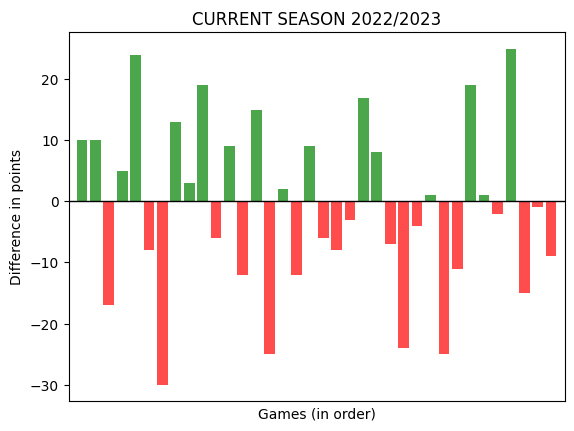

In [67]:
currentSeasonBarPlot('ATL');

WIN/LOSS

In [59]:
def winsLossesPer(DF_PULL_SEASON_RANGE):
    team_games_win_loss = (DF_PULL_SEASON_RANGE['W/L'] == 'W');

    number_of_wins = team_games_win_loss.sum();
    percent_wins = round(number_of_wins/len(team_games_win_loss),2);

    number_of_losses = len(team_games_win_loss) - number_of_wins;
    percent_losses = round(1 - percent_wins,2);

    fig = plt.figure(2);
    plt.pie([number_of_wins, number_of_losses], labels=[f"Wins {percent_wins}%", f"Losses {percent_losses}%"], colors=["green", "red"]);
    plt.title(f"WINS|LOSSES PERCENTAGES");

    return fig;

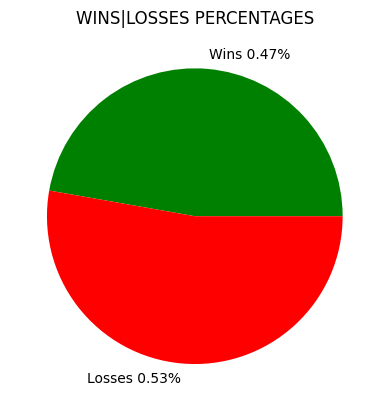

In [68]:
winsLossesPer(DF_PULL_SEASON_RANGE);

POINTS PER GAME

In [60]:
def teamPointsPerGame(DF_PULL_SEASON_RANGE, TEAM):
    points_per_game = DF_PULL_SEASON_RANGE['Tm'];

    fig = plt.figure(3);

    plt.hist(points_per_game, color="#030f20");
    plt.vlines(points_per_game.mean(), 
        plt.ylim()[0], 
        plt.ylim()[1], 
        color="#ff8800", 
        label=f"Mean {round(points_per_game.mean(),2)}"
    );
    plt.title(f"{TEAM} POINTS SCORED PER GAME");
    plt.xlabel("Number of points");
    plt.ylabel("Count");
    plt.legend();
    

    return fig;

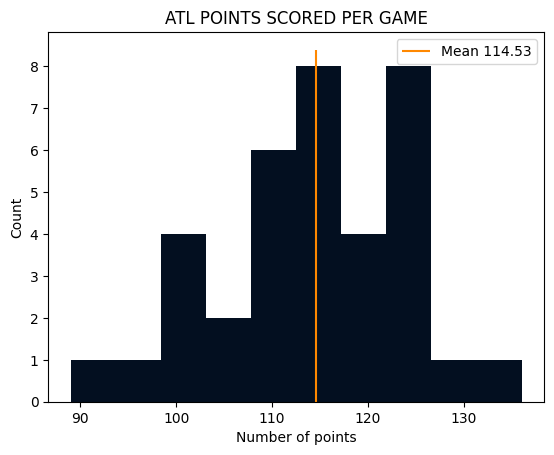

In [69]:
teamPointsPerGame(DF_PULL_SEASON_RANGE,'ATL');

OPPONENT POINTS PER GAME

In [61]:
def ooPPointsPerGame(DF_PULL_SEASON_RANGE, TEAM):
    opponent_points_per_game = DF_PULL_SEASON_RANGE['OppP'];

    fig = plt.figure(4);

    plt.hist(opponent_points_per_game, color="#030f20");
    plt.vlines(opponent_points_per_game.mean(), 
        plt.ylim()[0], 
        plt.ylim()[1], 
        color="#ff8800", 
        label=f"Mean {round(opponent_points_per_game.mean(),2)}"
    );
    plt.title(f"OPPONENTS POINTS SCORED PER GAME AGAINTS {TEAM}");
    plt.xlabel("Number of points");
    plt.ylabel("Count");
    plt.legend();

    return fig;

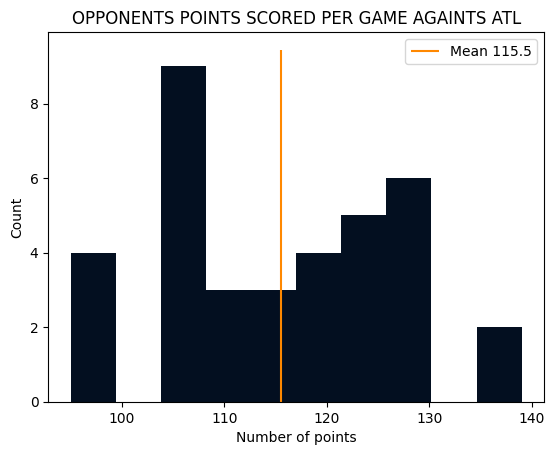

In [70]:
ooPPointsPerGame(DF_PULL_SEASON_RANGE,'ATL');

BOX PLOTS ON POINTS SCORED PER GAME

In [72]:
def pointsScoreBoxPlots(DF_PULL_SEASON_RANGE, TEAM):
    points_per_game = DF_PULL_SEASON_RANGE['Tm'];
    opponent_points_per_game = DF_PULL_SEASON_RANGE['OppP'];

    fig = plt.figure(5);

    boxplot = plt.boxplot(
        (points_per_game, opponent_points_per_game), 
        notch=True, sym=".", 
        patch_artist=True, 
        boxprops=dict(facecolor="#030f20"),
        medianprops=dict(color="white"),
        whiskerprops=dict(color="#030f20"),
        capprops=dict(color="#030f20"));
    plt.title("POINTS SCORED PER GAME");
    plt.xticks(ticks=[1,2],labels=[f"{TEAM}", f"Opponents againts {TEAM}"]);
    plt.ylabel("Points");

    return fig;

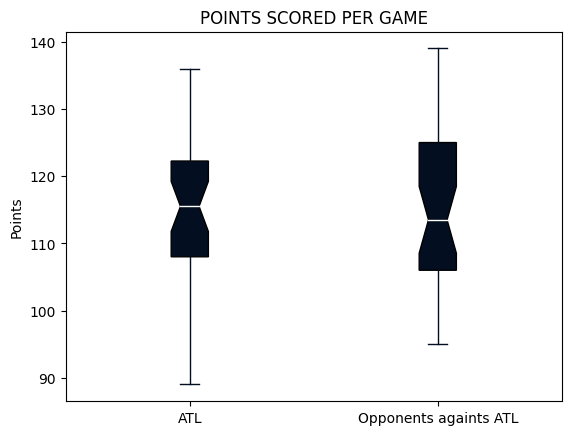

In [73]:
pointsScoreBoxPlots(DF_PULL_SEASON_RANGE,'ATL');

### SIMULATION

In [63]:
"""
Given n,p compute c such that expected value is >= 0

n := bet amount;
c := odds * 100;
p := probability of event * 100;

(n(c/100) - n)(p/100) - n((100-p)/100) >= 0

let n = 1:

    => c >= 10^4/p 

"""

# CASH = 500;
# TRIALS = 100000;
# number_of_match = 50;
# bet = 5;
# years = TRIALS;
# BANKRUPT = False;
# end_of_months = np.array([]);
# end_of_years = np.array([]);

# event_probability = 0.70;
# quote = 1.5

# while years > 0:
#     money = CASH;
#     month = 12;
#     while month > 0:
#         for _ in range(number_of_match):
#             if random.random() < event_probability:
#                 money += (bet*quote- bet);
#             else:
#                 money -= bet;

#             if money <= 0:
#                 print("BANKRUPT")
#                 BANKRUPT = True;
#                 break;

#         if BANKRUPT == True:
#             break;

#         end_of_months = np.append(end_of_months, money)
#         month -= 1;

#     if BANKRUPT == True:
#         break;

#     end_of_years = np.append(end_of_years, money)
#     years -= 1;

# plt.plot(np.arange(TRIALS*12), end_of_months, color="red", marker="o", label=f"{len(end_of_months[end_of_months < CASH])/(TRIALS*12)} %");
# plt.hlines(CASH, 0, TRIALS*12, color="black");
# plt.legend();


In [64]:
# print("0-50 : ",len(end_of_months[np.where((CASH <= end_of_months) & (end_of_months < CASH+50))])/(TRIALS*12))
# print("50-100 : ",len(end_of_months[np.where((CASH+50 <= end_of_months) & (end_of_months < CASH+100))])/(TRIALS*12))
# print("100-150 : ",len(end_of_months[np.where((CASH+100 <= end_of_months) & (end_of_months < CASH+150))])/(TRIALS*12))
# print("150-200 : ",len(end_of_months[np.where((CASH+150 <= end_of_months) & (end_of_months < CASH+200))])/(TRIALS*12))
# print("200-250 : ",len(end_of_months[np.where((CASH+200 <= end_of_months) & (end_of_months < CASH+250))])/(TRIALS*12))

In [65]:
# plt.plot(np.arange(TRIALS), end_of_years, color="blue", marker="o", label=f"{len(end_of_years[end_of_years < CASH])/TRIALS} %");
# plt.hlines(CASH, 0, TRIALS, color="black");
# plt.legend();